In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import sys
from datetime import datetime
import numpy as np
sys.path.append("../")
sys.path.append("../../")
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = False)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
symbols_important = ["He", "She"]
symbols_dummy = ["died.", 
                 "died yesterday.",
                 "died yesterday in.", 
                 "died yesterday in a.", 
                 "died yesterday in a very.", 
                 "died yesterday in a very sad.", 
                 "died yesterday in a very sad way.", 
                 "died yesterday in a very sad way due.", 
                 "died yesterday in a very sad way due to.", 
                 "died yesterday in a very sad way due to a.",
                 "died yesterday in a very sad way due to a heart.", 
                 "died yesterday in a very sad way due to a heart attack."]

In [28]:

tokenizer.tokenize(symbols_dummy[11])

['Ġdied',
 'Ġyesterday',
 'Ġin',
 'Ġa',
 'Ġvery',
 'Ġsad',
 'Ġway',
 'Ġdue',
 'Ġto',
 'Ġa',
 'Ġheart',
 'Ġattack',
 '.']

In [3]:
prompt = tokenizer.decode(tokenizer.bos_token_id) + "The doctor was very famous."
input_ids = torch.tensor(tokenizer.encode(prompt)).reshape(1, -1).to(device)
print(input_ids)

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tensor([[50256,   383,  6253,   373,   845,  5863,    13]])


In [4]:
with torch.no_grad():
    output = model(input_ids)
    logits = output.logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)[0]

word_probs = {}
symbols_important_ids = [tokenizer.encode(sym) for sym in symbols_important]

for i in symbols_important_ids:
    word_prob = probs[i]
    word_probs[tokenizer.decode(i).replace(" ","")] = word_prob.item()

normalized_word_probs_he_she = {}
total = sum(word_probs.values())
for word in word_probs:
    normalized_word_probs_he_she[word] = word_probs[word] / total

    
normalized_word_probs_he_she

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


{'He': 0.9474213481974543, 'She': 0.0525786518025457}

In [5]:
split_lists = [sentence.split() for sentence in symbols_dummy]
split_lists

[['died.'],
 ['died', 'yesterday.'],
 ['died', 'yesterday', 'in.'],
 ['died', 'yesterday', 'in', 'a.'],
 ['died', 'yesterday', 'in', 'a', 'very.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to', 'a.'],
 ['died',
  'yesterday',
  'in',
  'a',
  'very',
  'sad',
  'way',
  'due',
  'to',
  'a',
  'heart.'],
 ['died',
  'yesterday',
  'in',
  'a',
  'very',
  'sad',
  'way',
  'due',
  'to',
  'a',
  'heart',
  'attack.']]

In [6]:
def calculate_probabilities_with_prompt(split_lists, index, tokenizer, model, device, symbol_choosen):
    sentence = split_lists[index]
    prompt = tokenizer.decode(tokenizer.bos_token_id) + " The doctor was very famous." + symbol_choosen

    for i in range(len(sentence)):
        word_probs.clear()
        current_sentence = sentence[i:]
        symbols_dummy_ids = [tokenizer.encode(sym) for sym in current_sentence]
        symbols_dummy_ids = [[token_id] for sublist in symbols_dummy_ids for token_id in sublist]
        prompt += " " + current_sentence[0]
        input_ids = torch.tensor(tokenizer.encode(prompt)).reshape(1, -1).to(device)
        
        with torch.no_grad():
            output = model(input_ids)
            logits = output.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)[0]

        for token_ids in symbols_dummy_ids:
            for token in token_ids:
                word_prob = probs[token]
                word_probs[tokenizer.decode(token).replace(" ","")] = word_prob.item()

        normalized_word_probs_dummy = {}
        total = sum(word_probs.values())
        for word in word_probs:
            normalized_word_probs_dummy[word] = word_probs[word] / total

        #print(f"Normalized probabilities for '{' '.join(current_sentence)}': {normalized_word_probs_dummy}")
    
    return normalized_word_probs_dummy

In [ ]:
# Selección aleatoria entre "He" y "She"
symbol_choosen = np.random.choice(list(normalized_word_probs_he_she.keys()), 
                                  p=list(normalized_word_probs_he_she.values()))
normalized_word_probs_dummy = calculate_probabilities_with_prompt(split_lists, 1, tokenizer, model, device, symbol_choosen)

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [8]:
from time import time
import numpy as np

def run_n_times(n, split_lists):
    all_times = []  # Lista para almacenar los tiempos de todas las llamadas

    for sentence_index, sentence in enumerate(split_lists):
        times = []  # Lista para almacenar los tiempos de cada oración

        for _ in range(n):  # Llamar a la función n veces
            start_time = time()
            symbol_chosen = np.random.choice(list(normalized_word_probs_he_she.keys()), 
                                              p=list(normalized_word_probs_he_she.values()))
            
            # Llamar a la función con el índice de la oración actual
            normalized_word_probs_dummy = calculate_probabilities_with_prompt(split_lists, sentence_index, tokenizer, model, device, symbol_chosen)
            elapsed_time = time() - start_time
            times.append(elapsed_time)

        all_times.append(times)  # Agregar los tiempos de esta oración a la lista principal

    return all_times


In [9]:
n = 5  
execution_times = run_n_times(n, split_lists)

In [10]:
import pandas as pd

data = {
    "sentence": [], 
    "time": []     
}

for sentence_index, times in enumerate(execution_times):
    for time in times:
        data["sentence"].append(sentence_index)  
        data["time"].append(time)               

df = pd.DataFrame(data)
df


,sentence,time
0,0,0.058758
1,0,0.042180
2,0,0.038107
3,0,0.037175
4,0,0.036209
5,1,0.070080
6,1,0.071763
7,1,0.069109
8,1,0.069211
9,1,0.069515


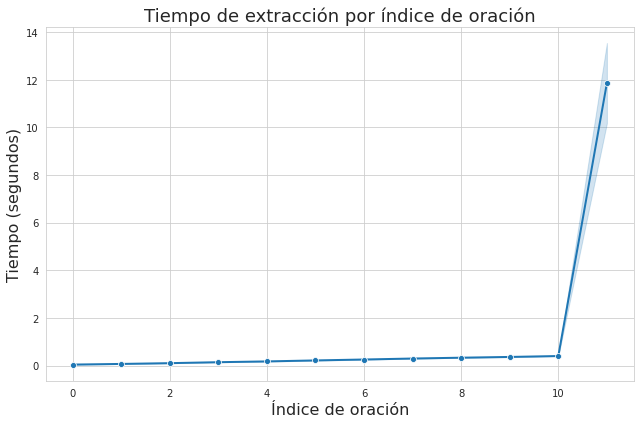

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(9, 6))
ax = sns.lineplot(x="sentence", y="time", data=df, marker="o", linewidth=2, markersize=6)
ax.set_title("Tiempo de extracción por índice de oración", fontsize=18)
ax.set_ylabel("Tiempo (segundos)", fontsize=16)
ax.set_xlabel("Índice de oración", fontsize=16)

plt.tight_layout()
plt.show()


In [14]:
import re

split_lists_dot = [re.findall(r'\S+|\.', sentence.replace('.', ' .')) for sentence in symbols_dummy]
split_lists_dot


[['died', '.'],
 ['died', 'yesterday', '.'],
 ['died', 'yesterday', 'in', '.'],
 ['died', 'yesterday', 'in', 'a', '.'],
 ['died', 'yesterday', 'in', 'a', 'very', '.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', '.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', '.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', '.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to', '.'],
 ['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to', 'a', '.'],
 ['died',
  'yesterday',
  'in',
  'a',
  'very',
  'sad',
  'way',
  'due',
  'to',
  'a',
  'heart',
  '.'],
 ['died',
  'yesterday',
  'in',
  'a',
  'very',
  'sad',
  'way',
  'due',
  'to',
  'a',
  'heart',
  'attack',
  '.']]

In [15]:
def calculate_probabilities_with_prompt_dot(split_lists, index, tokenizer, model, device, symbol_choosen):
    sentence = split_lists_dot[index]
    prompt = tokenizer.decode(tokenizer.bos_token_id) + " The doctor was very famous." + symbol_choosen

    for i in range(len(sentence)):
        word_probs.clear()
        current_sentence = sentence[i:]
        symbols_dummy_ids = [tokenizer.encode(sym) for sym in current_sentence]
        symbols_dummy_ids = [[token_id] for sublist in symbols_dummy_ids for token_id in sublist]
        prompt += " " + current_sentence[0]
        input_ids = torch.tensor(tokenizer.encode(prompt)).reshape(1, -1).to(device)
        
        print(prompt)

        with torch.no_grad():
            output = model(input_ids)
            logits = output.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)[0]

        for token_ids in symbols_dummy_ids:
            for token in token_ids:
                word_prob = probs[token]
                word_probs[tokenizer.decode(token).replace(" ","")] = word_prob.item()

        # Normalización de probabilidades
        normalized_word_probs_dummy = {}
        total = sum(word_probs.values())
        for word in word_probs:
            normalized_word_probs_dummy[word] = word_probs[word] / total

        print(f"Normalized probabilities for '{' '.join(current_sentence)}': {normalized_word_probs_dummy}")
    
    return normalized_word_probs_dummy

In [17]:
from time import time
import numpy as np

def run_n_times_dot(n, split_lists_dot):
    all_times = []  # Lista para almacenar los tiempos de todas las llamadas

    for sentence_index, sentence in enumerate(split_lists):
        times = []  # Lista para almacenar los tiempos de cada oración

        for _ in range(n):  # Llamar a la función n veces
            start_time = time()
            symbol_chosen = np.random.choice(list(normalized_word_probs_he_she.keys()), 
                                              p=list(normalized_word_probs_he_she.values()))
            
            # Llamar a la función con el índice de la oración actual
            normalized_word_probs_dummy = calculate_probabilities_with_prompt(split_lists_dot, sentence_index, tokenizer, model, device, symbol_chosen)
            elapsed_time = time() - start_time
            times.append(elapsed_time)

        all_times.append(times)  # Agregar los tiempos de esta oración a la lista principal

    return all_times


In [18]:
n = 5  
execution_times = run_n_times_dot(n, split_lists_dot)

In [21]:
import pandas as pd

data = {
    "sentence": [], 
    "time": []     
}

for sentence_index, times in enumerate(execution_times):
    for time in times:
        data["sentence"].append(sentence_index)  
        data["time"].append(time)               

df = pd.DataFrame(data)
df


,sentence,time
0,0,0.095711
1,0,0.069967
2,0,0.068069
3,0,0.067057
4,0,0.075230
5,1,0.105971
6,1,0.098398
7,1,0.106737
8,1,0.101295
9,1,0.104938


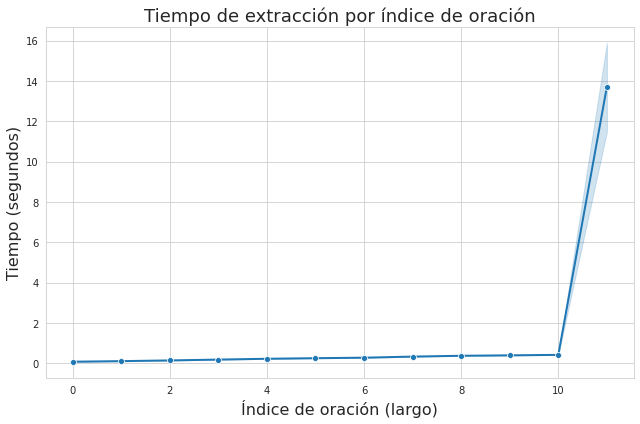

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(9, 6))
ax = sns.lineplot(x="sentence", y="time", data=df, marker="o", linewidth=2, markersize=6)
ax.set_title("Tiempo de extracción por índice de oración", fontsize=18)
ax.set_ylabel("Tiempo (segundos)", fontsize=16)
ax.set_xlabel("Índice de oración (largo)", fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
def calculate_probabilities_with_prompt_gpt(self, split_lists, index, symbol_chosen):
    sentence = split_lists[index]
    prompt = self.tokenizer.decode(self.tokenizer.bos_token_id) + " The doctor was very famous." + symbol_chosen

    word_probs = {}

    for i in range(len(sentence)):
        current_sentence = sentence[i:]
        input_ids = self.build_ids_sequence_from_tokens(current_sentence)

        with torch.no_grad():
            output = self.model(input_ids)
            logits = output.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Obtener las probabilidades de los símbolos deseados
        symbols_dummy = [self.tokenizer.decode(tokenizer.encode(sym)).replace(" ", "") for sym in current_sentence]
        symbol_probabilities = self._get_symbols_probabilities_dict(input_ids, probs, symbols_dummy)

        # Actualizar word_probs
        word_probs.update(symbol_probabilities)

    # Normalizar las probabilidades
    total = sum(word_probs.values())
    normalized_word_probs_dummy = {word: prob / total for word, prob in word_probs.items()}

    return normalized_word_probs_dummy
